<a href="https://colab.research.google.com/github/LSSTDESC/jax-perlmutter-tutorials/blob/main/notebooks/DESCJaxTutorial_Dec2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESC DC2 Telecon: Practical introduction to JAX

Author:
- [@EiffL](https://github.com/EiffL)(Francois Lanusse)

## Overview

The goal of this tutorial is to cover some of the essential JAX mechanisms, and
put them into practice for typical computations that may be required for a project like CCL.

**Learning objectives**:
- Summary of JAX features
- Implement integrations in JAX for things like CCL
- Implement image fitting in JAX for things like shape measurement
- Run an MCMC in batched parallel


## Previous DESC tutorials on JAX

We have already had a few sessions on JAX within DESC:

- [JAX for a cosmology library](https://slides.com/eiffl/jax-cosmo): A presentation on why jax is so nice for generic purpose coding
- [Intro to JAX tutorial](https://colab.research.google.com/drive/1kXElYNy7g3KFrkmn2iT4paL8kl66Bfyc?usp=sharing): A Colab tutorial covering all the JAX basics and some of the things which might surprise you



## A few words about JAX

What's the best Deep Learning and autodiff framework? TensorFlow? PyTorch? Wrong: all you ever want is JAX :-)


![](https://raw.githubusercontent.com/google/jax/main/images/jax_logo_250px.png)

JAX = NumPy + autograd + XLA

In other words, it looks like pure NumPy, but is automatically differentiable, and runs on XLA (i.e. GPU accelerated). Checkout the [full documentation](https://jax.readthedocs.io/en/latest/index.html) to discover the many awesome features JAX has to offer.

A few [slides about that](https://slides.com/eiffl/jax-cosmo#/4).


#### Autodiff

For our purposes, the most interesting feature of JAX will be automatic differentiation, which is performed using `jax.grad`




In [ ]:
!pip install --quiet jax-cosmo

     |████████████████████████████████| 282 kB 12.8 MB/s 


In [ ]:
%pylab inline
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cov', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# Let's build a function of x that returns a scalar
def f(x):
    y = 2*x+1
    return y

In [ ]:
# To get the derivative of this function, I simply use jax.grad
df_dx = jax.grad(f)

In [ ]:
df_dx

<function __main__.f>

`jax.grad` has *transformed* my function `f` into a new function that comptutes its gradient.

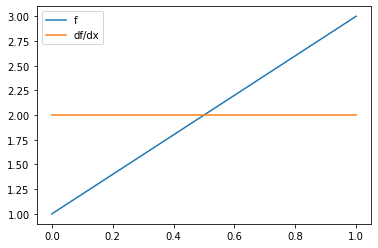

In [ ]:
u = jnp.linspace(0,1)
plot(u, f(u), label='f')
plot(u,jax.vmap(df_dx)(u), label='df/dx')
legend()

#### Vectorization with `vmap`

Another awesome feature of JAX is the ability to batch any function using the `jax.vmap` transformation. Say you have a function that works on a single example:

In [ ]:
def f(x):
    # Expect x to be of shape [16, 16]
    nx, ny = x.shape 
    x = x + jnp.ones([nx,ny])
    return x

In [ ]:
x = jnp.zeros([16,16])
f(x).shape

(16, 16)

In [ ]:
# But this function wouldn't work if I had a batch of images
x = jnp.zeros([1,16,16])
f(x).shape # THIS SHOULD FAIL

ValueError: ignored

In [ ]:
# But I can use jax magic
f_batched = jax.vmap(f)

x = jnp.zeros([1,16,16])
f_batched(x).shape

(1, 16, 16)

Tada! 

#### JIT compilation

The final super useful thing to know about JAX is that you can JIT (Just In Time) compile any function, they will be compiled as an XLA graph and completely bypass Python to run directly under XLA.

In [ ]:
def f(x, A):
    return A.dot(x)

f_jitted = jax.jit(f)

In [ ]:
x = randn(128)
A = randn(128,128)

In [ ]:
f_jitted(x,A);

On this example, jitting won't make much of a difference because it is  a tiny function, but we will see later that we can JIT the computation of the loss and update of a full neural network, which then becomes lightning fast.

## Autodiff showdown

Here are a few cool examples of autodiff to compare against Julia.

#### You can differentiate with respect to objects!

This is not possible in TensorFlow for instance. So imagine this:

In [ ]:
def myfunc(cosmo):
  return 2* cosmo["sigma8"]**2 + 1

In [ ]:
cosmo = {"sigma8": 0.8, "omega_m":0.3}

In [ ]:
jax.grad(myfunc)(cosmo)

{'omega_m': DeviceArray(0., dtype=float32),
 'sigma8': DeviceArray(3.2, dtype=float32)}

In this case this is a simple dictionary, but you can register your own objects
so that they can be recognized by JAX's autodiff. See [here](https://jax.readthedocs.io/en/latest/pytrees.html)

In jax-cosmo, you can take derivatives with respect to `objects` like redshift distributions, and cosmology :-)  

## Example of application: Cosmological computations and inference

### End-to-End Limber Integration Example

One of the most frequent things we need to do usually is evaluating an integral over a power spectrum.

In [ ]:
def simps(f, a, b, N=128):
  """ Simple Simspon's integration 
  Args:
    f: vectorized function providing the integrand
    a,b: float, interval of integraions
    N: integer, number of points to evaluate the integrand 
  """
  if N % 2 == 1:
      raise ValueError("N must be an even integer.")
  dx = (b - a) / N                # Step between points 
  x = jnp.linspace(a, b, N + 1)    # Grid for the evaluation of integrand
  y = f(x)                        # Evaluate the integrand on appropriate grid
  return dx / 3 * jnp.sum(y[0:-1:2] + 4 * y[1::2] + y[2::2], axis=0) # Simpson's rule

Let's try to use it to implement a limber integration:

In [ ]:
import jax_cosmo as jc
cosmo = jc.Planck15()                  # Create a cosmology with default parameters
nz = jc.redshift.smail_nz(1., 2.,  1.) # Create a Smail redshift distribution
tracer = jc.probes.WeakLensing([nz])   # Define a lensing probe

In [ ]:
def angular_cl(cosmo, tracer, ell, integration_fn=simps):

  @jax.vmap
  def limber(ell):
    """ Function that will perform a limber integration at a single ell
    """
    @jax.vmap
    def integrand(a):
      # Step 1: retrieve the associated comoving distance, clip to avoid stupid values
      chi = jnp.clip(jc.background.radial_comoving_distance(cosmo, a), 1e-2)
      
      # Step 2: get the power spectrum for this combination of chi and a
      pk = jc.power.nonlinear_matter_power(cosmo, k = (ell + 0.5) / chi, a = a) 

      # Step 3: retrieve the kernel
      kernel = tracer.kernel(cosmo, jc.utils.a2z(a), ell)

      # Step 4: computing the integrand
      return  pk * kernel**2 * jc.background.dchioverda(cosmo, a) / chi

    return integration_fn(integrand, jc.utils.z2a(tracer.zmax), 1.0) / jc.constants.c**2

  # Now, evaluate the Limber integral for an array of ell
  return limber(ell)

And that's it folks

In [ ]:
ell = np.logspace(1,3)
cls = angular_cl(cosmo, tracer, ell)

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


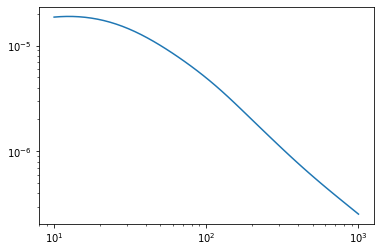

In [ ]:
loglog(ell, cls[:,0])

In [ ]:
# We can also jit it
jitted_angular_cl = jax.jit(angular_cl)

In [ ]:
%timeit jitted_angular_cl(cosmo, tracer, ell)

100 loops, best of 5: 8.78 ms per loop


### Instant Fisher Forecast

Because everything written in JAX is autodiffabe, we can in particular do things like computing Fisher matrices.

Let's try to derive the Fisher matrix, using the usual formula for constant
covariance:

$$ F_{\alpha, \beta} = \sum_{i,j} \frac{d \mu_i}{d \theta_\alpha} C^{-1}_{i,j} \frac{d \mu_j}{d \theta_\beta} $$

What we need in this expression, is the covariance matrix, which we already have
and the Jacobian of the mean with respect to parameters. Normally you would need to use finite differencing, but luckily we can get that easily with JAX:

In [ ]:
# Let's define a fiducial cosmology
cosmo = jc.Planck15()
params = np.array([cosmo.Omega_c, cosmo.sigma8]) 
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, [tracer], sparse=True);

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [ ]:
# We define a parameter dependent function that computes the mean
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1])
  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, [tracer])
  return m.flatten() # We want it in 1d to operate against the covariance matrix

In [ ]:
# We compute it's jacobian with JAX, and we JIT it for efficiency
jac_mean = jax.jit(jax.jacfwd(mean_fn))

In [ ]:
# We can now evaluate the jacobian at the fiducial cosmology
%timeit dmu = jac_mean(params)

10 loops, best of 5: 19.7 ms per loop


In [ ]:
dmu.shape

(50, 2)

In [ ]:
# For fun, we can also time it
%timeit jac_mean(params).block_until_ready()

10 loops, best of 5: 22.8 ms per loop


In [ ]:
# Now we can compose the Fisher matrix:
F_2 = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)

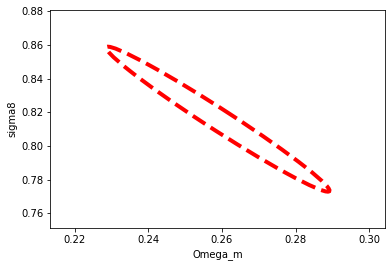

In [ ]:
# We can now plot contours obtained with this 
plot_contours(F_2, params, fill=False, color='red', lw=4, linestyle='dashed');
xlabel('Omega_m')
ylabel('sigma8');

### Batched MCMC on GPU

One of the huge advantage of GPUs is that they allow for massively parallel computing. For our purposes in cosmo, it means for instance that we can run massively parallel MCMC chains with just a few GPUs.

We are going to demonstrate it here with [TensorFlow Probability](https://www.tensorflow.org/probability)

In [ ]:
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

The first thing we need is to get a log likelihood

In [ ]:
@jax.jit
def log_likelihood(params):
  C = jnp.diag(jc.sparse.to_dense(cov))
  return tfd.MultivariateNormalDiag(loc=mean_fn(params), scale_diag=jnp.sqrt(C)).log_prob(mu)

And now we can use tensorflow probability to run an HMC sampler:

In [ ]:
@jax.jit
def get_samples():
  adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=log_likelihood,
          num_leapfrog_steps=3,
          step_size=0.005),
      num_adaptation_steps=20)

  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=200,
      num_burnin_steps=50,
      current_state=params+0.01,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      seed=jax.random.PRNGKey(0))
  return samples, is_accepted

In [ ]:
samples, is_accepted = get_samples()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


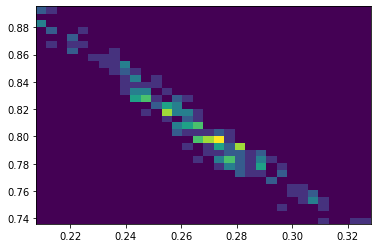

In [ ]:
hist2d(samples[:,0], samples[:,1],32);

Ok, I mean, that's cool, but you know what would be really cool? it's to run a bunch of chains in parallel!

In [ ]:
# We can batch the log likelihood
batched_log_likelihood = jax.vmap(log_likelihood)

In [ ]:
init_params = params.reshape([1,2]) + 0.05*randn(16,2)

In [ ]:
@jax.jit
def get_samples():
  adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
      tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=batched_log_likelihood,
          num_leapfrog_steps=3,
          step_size=0.005),
      num_adaptation_steps=20)

  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=200,
      num_burnin_steps=50,
      current_state=init_params,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
      seed=jax.random.PRNGKey(0))
  return samples, is_accepted

In [ ]:
samples, is_accepted = get_samples()

/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:6493: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [ ]:
# Removing non-accepted samples
samples = samples[0][samples[1]]
samples.shape

(10460, 2)

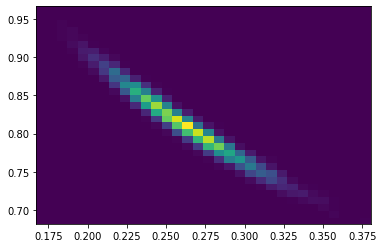

In [ ]:
hist2d(samples[:,0], samples[:,1],32);

Isn't that nice!!!!

And that's not  all! You can distribute the MCMC on all GPUs on a node using the `pmap` function in JAX. 

Checkout this great [tutorial on Distributed Inference with JAX](https://www.tensorflow.org/probability/examples/Distributed_Inference_with_JAX)!

## Fitting light profiles

Let's see if we can do an ngmix-like code on GPU easily.

In [ ]:
!pip install --quiet git+https://github.com/esheldon/ngmix.git
!pip install --quiet galsim
!pip install --quiet optax

In [ ]:
import numpy as np
import galsim
import ngmix

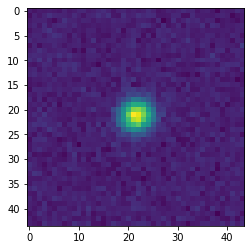

In [ ]:
# Generate some data
rng = np.random.RandomState(1234)

obs, obj_pars, true_im = make_data(rng=rng, noise=0.1)

imshow(obs.image)

#### Fitting that image with ngmix

In [ ]:
# fit the object to an exponential disk
prior = get_prior(rng=rng, scale=obs.jacobian.scale)
# fit using the levenberg marquards algorithm
fitter = ngmix.fitting.Fitter(model='gauss', prior=prior)


# make parameter guesses based on a psf flux and a rough T
guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
    rng=rng,
    T=0.25,
    prior=prior,
)

# psf fitting with coelliptical gaussians
psf_ngauss = 5
psf_fitter = ngmix.fitting.Fitter(model='gauss')
# special guesser for coelliptical gaussians
psf_guesser = ngmix.guessers.SimplePSFGuesser(rng=rng)

# this runs the fitter. We set ntry=2 to retry the fit if it fails
psf_runner = ngmix.runners.PSFRunner(
    fitter=psf_fitter, guesser=psf_guesser,
    ntry=2,
)
runner = ngmix.runners.Runner(
    fitter=fitter, guesser=guesser,
    ntry=2,
)

# this bootstraps the process, first fitting psfs then the object
boot = ngmix.bootstrap.Bootstrapper(
    runner=runner,
    psf_runner=psf_runner,
)

res = boot.go(obs)

In [ ]:
# Timing the fitting
%timeit res = boot.go(obs)

10 loops, best of 5: 20.3 ms per loop


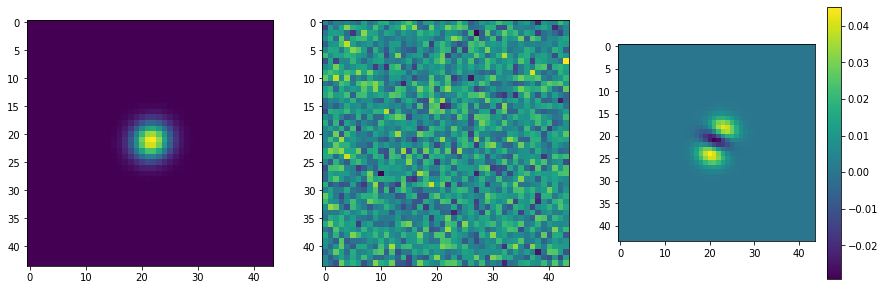

In [ ]:
# And let's see how it looks like
imfit = res.make_image()

figure(figsize=[15,5])
subplot(131)
imshow(imfit);
subplot(132)
imshow(obs.image - imfit);
subplot(133)
imshow(imfit - true_im); colorbar()

#### Doing more or less the same thing in JAX

(not exactly the same thing, ran out of time for including PSF)

In [ ]:
# Now the same thing in JAX
import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd = tfp.distributions

def galaxy_model(params):
  """ Forward model of our observations
  """
  dist = tfd.MultivariateNormalTriL(loc=params['center'] + 44/2,
                             scale_tril=tfp.bijectors.FillScaleTriL()(params['shape'])
                             )
  x,y = jnp.meshgrid(jnp.arange(44).astype('float32'), 
                     jnp.arange(44).astype('float32'))
  return params['amplitude']*dist.prob(jnp.stack([x,y], axis=-1))

In [ ]:
params={'center': jnp.zeros(2),
        'shape': jnp.ones(3),
        'amplitude': 10*jnp.ones(1)}

In [ ]:
im = galaxy_model(params)

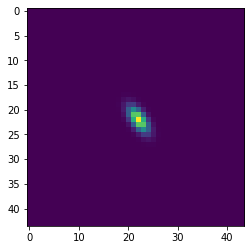

In [ ]:
imshow(im)

In [ ]:
# Let's fit!
from jax.scipy.optimize import minimize

@jax.jit
def do_fit(im):

  def loss(params):
    """ Loss function, Gaussian likelihood
    """
    center = params[:2]
    shape = params[2:5]
    amplitude = params[-1]
    return jnp.sum((im - galaxy_model({'center': center,
                                              'shape': shape,
                                              'amplitude': amplitude}))**2)
  params={'center': jnp.zeros(2),
          'shape': jnp.ones(3),
          'amplitude': 10*jnp.ones(1)}

  # We use minimize as in normal scipy
  opt_params = minimize(loss, 
         jnp.concatenate([params['center'],
                          params['shape'],
                          params['amplitude']]), method='BFGS')
  
  return {'center': opt_params.x[:2],
           'shape': opt_params.x[2:5],
           'amplitude': opt_params.x[5]}

In [ ]:
im = jnp.array(obs.image)
fitted_params = do_fit(im)

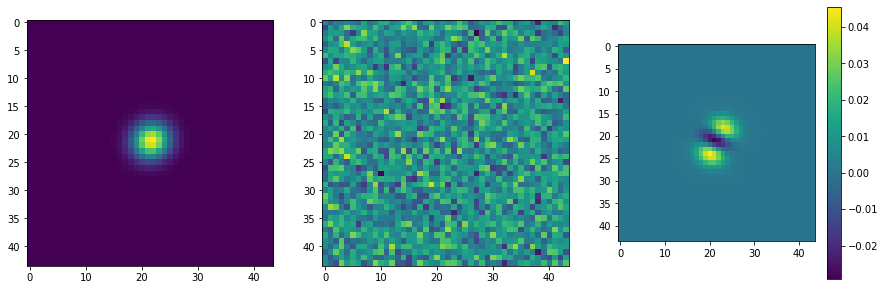

In [ ]:
figure(figsize=[15,5])
subplot(131)
imshow(galaxy_model(fitted_params));
subplot(132)
imshow(obs.image - galaxy_model(fitted_params));
subplot(133)
imshow(galaxy_model(fitted_params) - true_im); colorbar()

In [ ]:
%timeit do_fit(im)

100 loops, best of 5: 17.6 ms per loop


Hum ok, not super mind-blowing, but that's because the size of the problem is very small!

BUT! at no extra cost, we can just batch our fitting function!

In [ ]:
batched_fit = jax.jit(jax.vmap(do_fit))

# Create a batch of 2048 
ims = jnp.repeat(im.reshape([1,44,44]), 2048, 0)

In [ ]:
%timeit batched_fit(ims)

1 loop, best of 5: 3.71 s per loop


In [ ]:
# So it's that many ms
3.7/2048*1000

1.806640625